In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import ETFs as etf


Total number of ETFs: 33


In [ ]:
class MonteCarloSimulation:
    def __init__(self, ticker, end_date, start_date=None, initial_capital=100):
        etf_info = yf.download(ticker, start=start_date, end=end_date).iloc[::-1]
        etf_close = etf_info["Close"]
        self.etf = etf_close.columns[0]
        self.start_date = start_date
        self.end_date = end_date
        self.close = etf_close
        self.monthly_price = self.close.resample('ME').last()
        self.price_change = self.__compute_price_change()
        self.initial_capital = initial_capital  
        self.start_shares = self.initial_capital / self.monthly_price.iloc[-1] 

    def __compute_price_change(self):
        return self.monthly_price.pct_change().dropna().squeeze().to_numpy()

    def simulate_MC_sample(self, n_months):
        values = [self.initial_capital]  
        for _ in range(n_months):
            values.append(values[-1] * (1 + random.choice(self.price_change)))  #
        return values

    def plot_without_inflation(self):
        return self.plot_result(self.monthly_price, "without inflation")

    def run_simulation(self, n_simulations=100000, n_months=60):
        self.simulated_results = []
        for _ in range(n_simulations):
            self.simulated_results.append(self.simulate_MC_sample(n_months))
        return self.simulated_results
    
    def plot_result(self, n_simulations=100000, n_months=60):
        plt.figure(figsize=(10, 6))
        cmap = plt.get_cmap('tab20')
        colors = [cmap(i / n_simulations) for i in range(n_simulations)]
        for i, result in enumerate(self.simulated_results):
            plt.plot(result, color=colors[i])
            
        plt.title(f"{self.etf} Investment Growth Over {n_months} Months, ({n_simulations} Simulations)")
        plt.xlabel("Months")
        plt.ylabel("Portfolio Value (USD)")
        plt.grid(True)
        plt.show()
    

    def summarize_simulation(self, n_months = 60, annual_inflation=0.066):
        inflation_factor = (1 + annual_inflation) ** (n_months / 12)
        absolute_losses = 0
        cpi_adjusted_losses = 0
        gain_50 = 0
        gain_100 = 0
        gain_200 = 0

        for result in self.simulated_results:
            final = result[n_months]
            real_gain = final / inflation_factor
    
            if final < self.initial_capital:
                absolute_losses += 1
            if real_gain < self.initial_capital:
                cpi_adjusted_losses += 1
            if real_gain > self.initial_capital * 1.5:
                gain_50 += 1
            if real_gain > self.initial_capital * 2:
                gain_100 += 1
            if real_gain > self.initial_capital * 3:
                gain_200 += 1
    
        total = len(self.simulated_results)
        print(f"{'--------' + self.etf + '--------':<40}{'Percent':>11}")
        print(f"{'Money lost (absolute USD)':<40} {absolute_losses / total * 100:>9.1f}%")
        print(f"{'Money lost (inflation-adjusted USD)':<40} {cpi_adjusted_losses / total * 100:>9.1f}%")
        print(f"{'Inflation-adjusted gain >50%':<40} {gain_50 / total * 100:>9.1f}%")
        print(f"{'Inflation-adjusted gain >100%':<40} {gain_100 / total * 100:>9.1f}%")
        print(f"{'Inflation-adjusted gain >200%':<40} {gain_200 / total * 100:>9.1f}%")

        return {
            'ETF': self.etf,
            'Money Lost (absolute)': absolute_losses / total * 100,
            'Money Lost (inflation-adjusted)': cpi_adjusted_losses / total * 100,
            'Inflation-Adjusted Gain >50%': gain_50 / total * 100,
            'Inflation-Adjusted Gain >100%': gain_100 / total * 100,
            'Inflation-Adjusted Gain >200%': gain_200 / total * 100,
        }




[*********************100%***********************]  1 of 1 completed


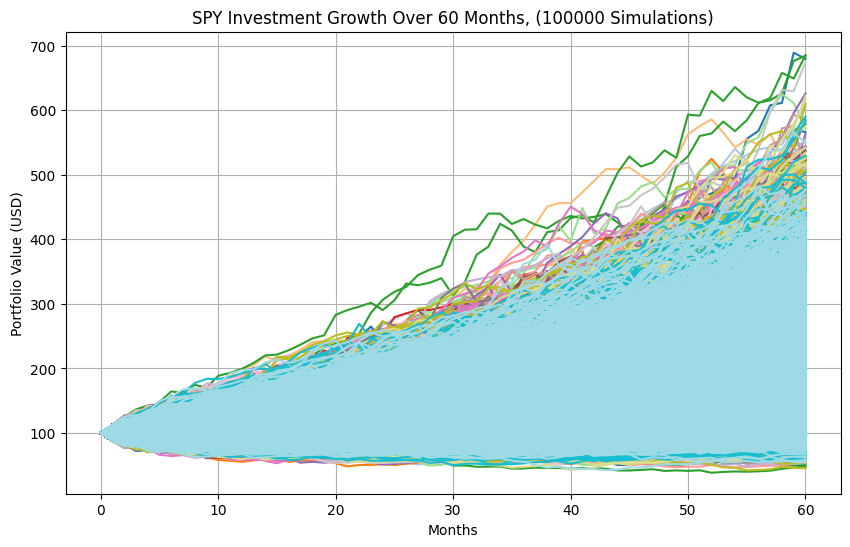

--------SPY--------                         Percent
Money lost (absolute USD)                      2.3%
Money lost (inflation-adjusted USD)           15.5%
Inflation-adjusted gain >50%                  39.8%
Inflation-adjusted gain >100%                 11.8%
Inflation-adjusted gain >200%                  0.6%


{'ETF': 'SPY',
 'Money Lost (absolute)': 2.32,
 'Money Lost (inflation-adjusted)': 15.536,
 'Inflation-Adjusted Gain >50%': 39.754,
 'Inflation-Adjusted Gain >100%': 11.76,
 'Inflation-Adjusted Gain >200%': 0.5910000000000001}

In [6]:
start_date = '2012-01-01'
end_date = '2025-3-31'
ticker = 'SPY'
n = 100000
mc_spy = MonteCarloSimulation(ticker, end_date, start_date=start_date)
mc_spy.run_simulation(n_simulations=n, n_months=60)
mc_spy.plot_result(n_simulations=n, n_months=60)


# ------------------Run 100,000 simulations------------------
mc_spy.run_simulation(n_simulations=n, n_months=60)
mc_spy.summarize_simulation(n_months=60, annual_inflation=0.066)


In [7]:
print(f"All assets:\n {etf.etfs}")

All assets:
 ['SPY', 'ASHR.L', 'VPL', 'INDA', 'TLT', 'EMXC', 'IEMG', 'XMAF.L', 'VDNR.L', 'KSA', 'EDEN', 'VGK', 'SEMI.AS', 'AIEQ', 'BCHN.L', 'GLD', 'SLV', 'USO', 'DBO', 'CORN', 'PSCC', 'VDE', 'IDUP.L', 'VNQ', 'EWU', 'EWS', 'EWW', 'EWJ', 'EWH', 'EWG', 'EWQ', 'EWC', 'EWA']


In [8]:
summary_rows = []

for etf_name in etf.etfs:
    print(f"------------------------- {etf_name}-------------------------")
    mc = MonteCarloSimulation(etf_name, end_date, start_date=start_date)
    mc.run_simulation(n_simulations=100000, n_months=60)
    summary = mc.summarize_simulation(n_months=60, annual_inflation=0.066)
    summary_rows.append(summary)
    
summary_df = pd.DataFrame(summary_rows)
display(summary_df)
summary_df.to_csv("monte_carlo_summary.csv", index=False)

------------------------- SPY-------------------------


[*********************100%***********************]  1 of 1 completed


--------SPY--------                         Percent
Money lost (absolute USD)                      2.4%
Money lost (inflation-adjusted USD)           15.7%
Inflation-adjusted gain >50%                  39.8%
Inflation-adjusted gain >100%                 11.7%
Inflation-adjusted gain >200%                  0.5%
------------------------- ASHR.L-------------------------


[*********************100%***********************]  1 of 1 completed


--------ASHR.L--------                      Percent
Money lost (absolute USD)                     33.5%
Money lost (inflation-adjusted USD)           56.4%
Inflation-adjusted gain >50%                  18.2%
Inflation-adjusted gain >100%                  7.7%
Inflation-adjusted gain >200%                  1.5%
------------------------- VPL-------------------------


[*********************100%***********************]  1 of 1 completed


--------VPL--------                         Percent
Money lost (absolute USD)                     19.3%
Money lost (inflation-adjusted USD)           55.1%
Inflation-adjusted gain >50%                   7.8%
Inflation-adjusted gain >100%                  1.0%
Inflation-adjusted gain >200%                  0.0%
------------------------- INDA-------------------------


[*********************100%***********************]  1 of 1 completed


--------INDA--------                        Percent
Money lost (absolute USD)                     22.7%
Money lost (inflation-adjusted USD)           49.5%
Inflation-adjusted gain >50%                  16.5%
Inflation-adjusted gain >100%                  4.6%
Inflation-adjusted gain >200%                  0.3%
------------------------- TLT-------------------------


[*********************100%***********************]  1 of 1 completed


--------TLT--------                         Percent
Money lost (absolute USD)                     47.7%
Money lost (inflation-adjusted USD)           84.5%
Inflation-adjusted gain >50%                   1.0%
Inflation-adjusted gain >100%                  0.1%
Inflation-adjusted gain >200%                  0.0%
------------------------- EMXC-------------------------


[*********************100%***********************]  1 of 1 completed


--------EMXC--------                        Percent
Money lost (absolute USD)                     32.8%
Money lost (inflation-adjusted USD)           63.7%
Inflation-adjusted gain >50%                   8.2%
Inflation-adjusted gain >100%                  1.6%
Inflation-adjusted gain >200%                  0.1%
------------------------- IEMG-------------------------


[*********************100%***********************]  1 of 1 completed


--------IEMG--------                        Percent
Money lost (absolute USD)                     31.8%
Money lost (inflation-adjusted USD)           66.0%
Inflation-adjusted gain >50%                   6.0%
Inflation-adjusted gain >100%                  0.9%
Inflation-adjusted gain >200%                  0.0%
------------------------- XMAF.L-------------------------


[*********************100%***********************]  1 of 1 completed


--------XMAF.L--------                      Percent
Money lost (absolute USD)                     46.5%
Money lost (inflation-adjusted USD)           74.8%
Inflation-adjusted gain >50%                   4.9%
Inflation-adjusted gain >100%                  0.9%
Inflation-adjusted gain >200%                  0.0%
------------------------- VDNR.L-------------------------


[*********************100%***********************]  1 of 1 completed


--------VDNR.L--------                      Percent
Money lost (absolute USD)                      4.5%
Money lost (inflation-adjusted USD)           23.0%
Inflation-adjusted gain >50%                  30.8%
Inflation-adjusted gain >100%                  7.8%
Inflation-adjusted gain >200%                  0.3%
------------------------- KSA-------------------------


[*********************100%***********************]  1 of 1 completed


--------KSA--------                         Percent
Money lost (absolute USD)                     18.3%
Money lost (inflation-adjusted USD)           45.2%
Inflation-adjusted gain >50%                  19.1%
Inflation-adjusted gain >100%                  5.7%
Inflation-adjusted gain >200%                  0.5%
------------------------- EDEN-------------------------


[*********************100%***********************]  1 of 1 completed


--------EDEN--------                        Percent
Money lost (absolute USD)                      5.6%
Money lost (inflation-adjusted USD)           23.1%
Inflation-adjusted gain >50%                  36.0%
Inflation-adjusted gain >100%                 12.6%
Inflation-adjusted gain >200%                  1.2%
------------------------- VGK-------------------------


[*********************100%***********************]  1 of 1 completed


--------VGK--------                         Percent
Money lost (absolute USD)                     17.1%
Money lost (inflation-adjusted USD)           46.3%
Inflation-adjusted gain >50%                  15.5%
Inflation-adjusted gain >100%                  3.5%
Inflation-adjusted gain >200%                  0.1%
------------------------- SEMI.AS-------------------------


[*********************100%***********************]  1 of 1 completed


--------SEMI.AS--------                     Percent
Money lost (absolute USD)                     31.9%
Money lost (inflation-adjusted USD)           50.7%
Inflation-adjusted gain >50%                  26.1%
Inflation-adjusted gain >100%                 14.0%
Inflation-adjusted gain >200%                  4.4%
------------------------- AIEQ-------------------------


[*********************100%***********************]  1 of 1 completed


--------AIEQ--------                        Percent
Money lost (absolute USD)                     23.4%
Money lost (inflation-adjusted USD)           46.6%
Inflation-adjusted gain >50%                  23.2%
Inflation-adjusted gain >100%                  9.3%
Inflation-adjusted gain >200%                  1.5%
------------------------- BCHN.L-------------------------


[*********************100%***********************]  1 of 1 completed


--------BCHN.L--------                      Percent
Money lost (absolute USD)                     19.8%
Money lost (inflation-adjusted USD)           32.6%
Inflation-adjusted gain >50%                  48.0%
Inflation-adjusted gain >100%                 34.1%
Inflation-adjusted gain >200%                 18.2%
------------------------- GLD-------------------------


[*********************100%***********************]  1 of 1 completed


--------GLD--------                         Percent
Money lost (absolute USD)                     27.3%
Money lost (inflation-adjusted USD)           65.0%
Inflation-adjusted gain >50%                   5.1%
Inflation-adjusted gain >100%                  0.6%
Inflation-adjusted gain >200%                  0.0%
------------------------- SLV-------------------------


[*********************100%***********************]  1 of 1 completed


--------SLV--------                         Percent
Money lost (absolute USD)                     51.5%
Money lost (inflation-adjusted USD)           71.8%
Inflation-adjusted gain >50%                  10.5%
Inflation-adjusted gain >100%                  4.2%
Inflation-adjusted gain >200%                  0.8%
------------------------- USO-------------------------


[*********************100%***********************]  1 of 1 completed


--------USO--------                         Percent
Money lost (absolute USD)                     71.0%
Money lost (inflation-adjusted USD)           82.7%
Inflation-adjusted gain >50%                   7.2%
Inflation-adjusted gain >100%                  3.4%
Inflation-adjusted gain >200%                  0.8%
------------------------- DBO-------------------------


[*********************100%***********************]  1 of 1 completed


--------DBO--------                         Percent
Money lost (absolute USD)                     62.9%
Money lost (inflation-adjusted USD)           80.0%
Inflation-adjusted gain >50%                   6.6%
Inflation-adjusted gain >100%                  2.3%
Inflation-adjusted gain >200%                  0.4%
------------------------- CORN-------------------------


[*********************100%***********************]  1 of 1 completed


--------CORN--------                        Percent
Money lost (absolute USD)                     76.3%
Money lost (inflation-adjusted USD)           92.6%
Inflation-adjusted gain >50%                   0.9%
Inflation-adjusted gain >100%                  0.1%
Inflation-adjusted gain >200%                  0.0%
------------------------- PSCC-------------------------


[*********************100%***********************]  1 of 1 completed


--------PSCC--------                        Percent
Money lost (absolute USD)                      7.3%
Money lost (inflation-adjusted USD)           28.5%
Inflation-adjusted gain >50%                  28.1%
Inflation-adjusted gain >100%                  8.1%
Inflation-adjusted gain >200%                  0.5%
------------------------- VDE-------------------------


[*********************100%***********************]  1 of 1 completed


--------VDE--------                         Percent
Money lost (absolute USD)                     34.8%
Money lost (inflation-adjusted USD)           55.0%
Inflation-adjusted gain >50%                  21.4%
Inflation-adjusted gain >100%                 10.3%
Inflation-adjusted gain >200%                  2.7%
------------------------- IDUP.L-------------------------


[*********************100%***********************]  1 of 1 completed


--------IDUP.L--------                      Percent
Money lost (absolute USD)                     23.0%
Money lost (inflation-adjusted USD)           53.0%
Inflation-adjusted gain >50%                  12.3%
Inflation-adjusted gain >100%                  2.5%
Inflation-adjusted gain >200%                  0.1%
------------------------- VNQ-------------------------


[*********************100%***********************]  1 of 1 completed


--------VNQ--------                         Percent
Money lost (absolute USD)                     18.5%
Money lost (inflation-adjusted USD)           47.4%
Inflation-adjusted gain >50%                  15.9%
Inflation-adjusted gain >100%                  3.9%
Inflation-adjusted gain >200%                  0.2%
------------------------- EWU-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWU--------                         Percent
Money lost (absolute USD)                     23.9%
Money lost (inflation-adjusted USD)           58.4%
Inflation-adjusted gain >50%                   7.9%
Inflation-adjusted gain >100%                  1.2%
Inflation-adjusted gain >200%                  0.0%
------------------------- EWS-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWS--------                         Percent
Money lost (absolute USD)                     31.3%
Money lost (inflation-adjusted USD)           63.2%
Inflation-adjusted gain >50%                   8.1%
Inflation-adjusted gain >100%                  1.5%
Inflation-adjusted gain >200%                  0.1%
------------------------- EWW-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWW--------                         Percent
Money lost (absolute USD)                     44.0%
Money lost (inflation-adjusted USD)           68.5%
Inflation-adjusted gain >50%                   9.6%
Inflation-adjusted gain >100%                  2.9%
Inflation-adjusted gain >200%                  0.3%
------------------------- EWJ-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWJ--------                         Percent
Money lost (absolute USD)                     16.2%
Money lost (inflation-adjusted USD)           51.8%
Inflation-adjusted gain >50%                   8.7%
Inflation-adjusted gain >100%                  1.1%
Inflation-adjusted gain >200%                  0.0%
------------------------- EWH-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWH--------                         Percent
Money lost (absolute USD)                     34.0%
Money lost (inflation-adjusted USD)           63.9%
Inflation-adjusted gain >50%                   9.2%
Inflation-adjusted gain >100%                  2.2%
Inflation-adjusted gain >200%                  0.2%
------------------------- EWG-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWG--------                         Percent
Money lost (absolute USD)                     21.7%
Money lost (inflation-adjusted USD)           48.6%
Inflation-adjusted gain >50%                  17.9%
Inflation-adjusted gain >100%                  5.4%
Inflation-adjusted gain >200%                  0.5%
------------------------- EWQ-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWQ--------                         Percent
Money lost (absolute USD)                     17.0%
Money lost (inflation-adjusted USD)           43.5%
Inflation-adjusted gain >50%                  20.1%
Inflation-adjusted gain >100%                  5.9%
Inflation-adjusted gain >200%                  0.5%
------------------------- EWC-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWC--------                         Percent
Money lost (absolute USD)                     25.1%
Money lost (inflation-adjusted USD)           57.0%
Inflation-adjusted gain >50%                  10.2%
Inflation-adjusted gain >100%                  1.9%
Inflation-adjusted gain >200%                  0.1%
------------------------- EWA-------------------------


[*********************100%***********************]  1 of 1 completed


--------EWA--------                         Percent
Money lost (absolute USD)                     29.8%
Money lost (inflation-adjusted USD)           58.2%
Inflation-adjusted gain >50%                  12.3%
Inflation-adjusted gain >100%                  3.1%
Inflation-adjusted gain >200%                  0.2%


,ETF,Money Lost (absolute),Money Lost (inflation-adjusted),Inflation-Adjusted Gain >50%,Inflation-Adjusted Gain >100%,Inflation-Adjusted Gain >200%
0,SPY,2.399,15.748,39.818,11.663,0.544
1,ASHR.L,33.485,56.378,18.247,7.670,1.452
2,VPL,19.338,55.114,7.755,0.969,0.010
3,INDA,22.702,49.515,16.520,4.552,0.339
4,TLT,47.683,84.501,1.003,0.064,0.000
5,EMXC,32.839,63.734,8.181,1.553,0.061
6,IEMG,31.805,65.973,5.957,0.922,0.017
7,XMAF.L,46.469,74.797,4.880,0.917,0.035
8,VDNR.L,4.468,22.977,30.793,7.827,0.326
9,KSA,18.315,45.160,19.054,5.715,0.493


In [9]:
best_etf = summary_df.sort_values(by='Money Lost (inflation-adjusted)', ascending=True).iloc[0]
print(f"The best performing ETF is: {best_etf['ETF']}")
print(best_etf)


The best performing ETF is: SPY
ETF                                   SPY
Money Lost (absolute)               2.399
Money Lost (inflation-adjusted)    15.748
Inflation-Adjusted Gain >50%       39.818
Inflation-Adjusted Gain >100%      11.663
Inflation-Adjusted Gain >200%       0.544
Name: 0, dtype: object
